# Proyek Klasifikasi Gambar: Intel Image
- **Nama:** Agung Nugraha
- **Email:** anugrah171819@gmail.com
- **ID Dicoding:** agungngrhhhh

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
!pip install tensorflowjs
import tensorflowjs as tfjs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback

from google.colab import files
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation

###Data Loading

In [ ]:
# Unggah file json API kaggle
files.upload()

In [ ]:
# Buat folder
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

In [ ]:
# Ambil nama folder/kelas
base_dir = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
class_name = os.listdir(base_dir)
print(class_name)

['Stone', 'Tumor', 'Cyst', 'Normal']


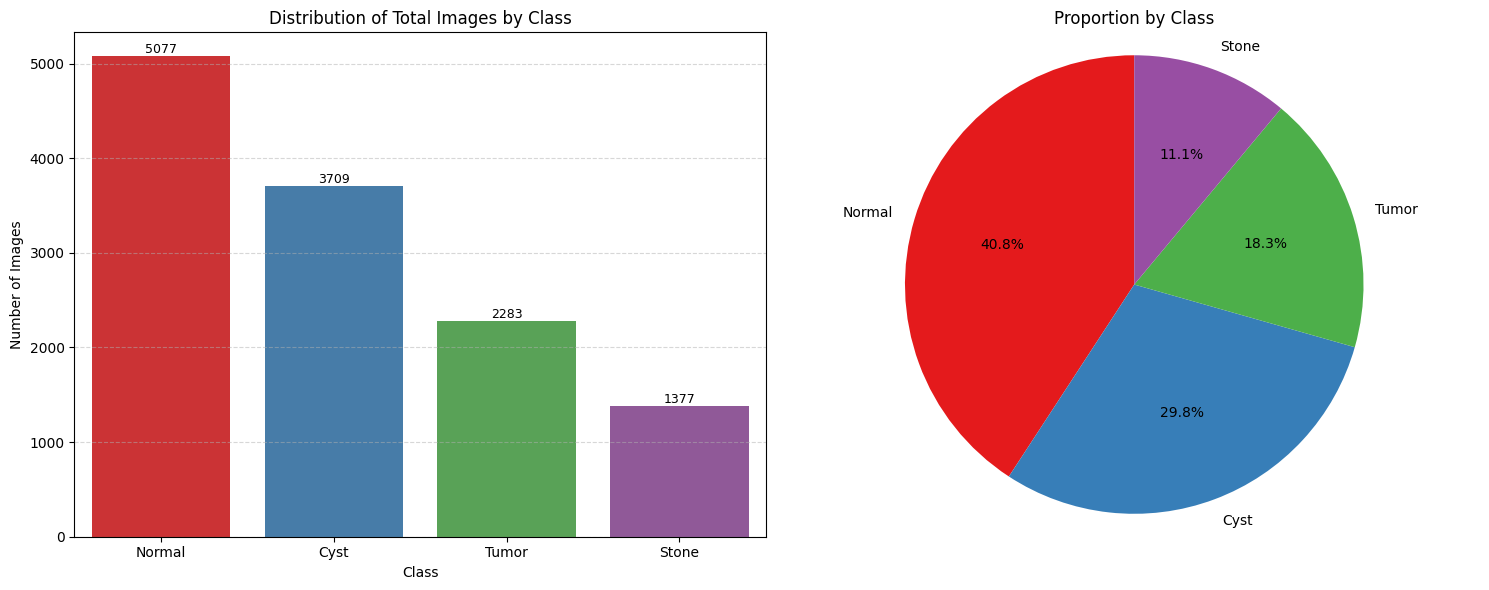

In [ ]:
# fungsi untuk melihat distribusi data
def distributionClass(base_dir, class_name):
    # Looping file dalam folder kelas
    class_count = {}
    for label in class_name:
        folder_path = os.path.join(base_dir, label)
        if os.path.isdir(folder_path):
            class_count[label] = len(os.listdir(folder_path))

    # Urutkan descending
    class_count = dict(sorted(class_count.items(), key=lambda x: x[1], reverse=True))

    # Ambil key dan valuenya
    labels = list(class_count.keys())
    values = list(class_count.values())
    palette = sns.color_palette('Set1', n_colors=len(labels))

    # set inisiasi ukuran plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Barplot
    sns.barplot(x=labels, y=values, palette=palette, ax=axes[0])
    axes[0].set_title('Distribution of Total Images by Class')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Number of Images')
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)

    # Tambahkan label diatas bar
    for p in axes[0].patches:
        h = p.get_height()
        axes[0].text(p.get_x() + p.get_width()/2, h + 0.5, f'{int(h)}',
                     ha='center', va='bottom', fontsize=9)

    # Pie chart
    axes[1].pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=palette)
    axes[1].set_title('Proportion by Class')
    axes[1].axis('equal')

    plt.tight_layout()
    plt.show()

    return class_count

# Panggil fungsi
class_count = distributionClass(base_dir, class_name)

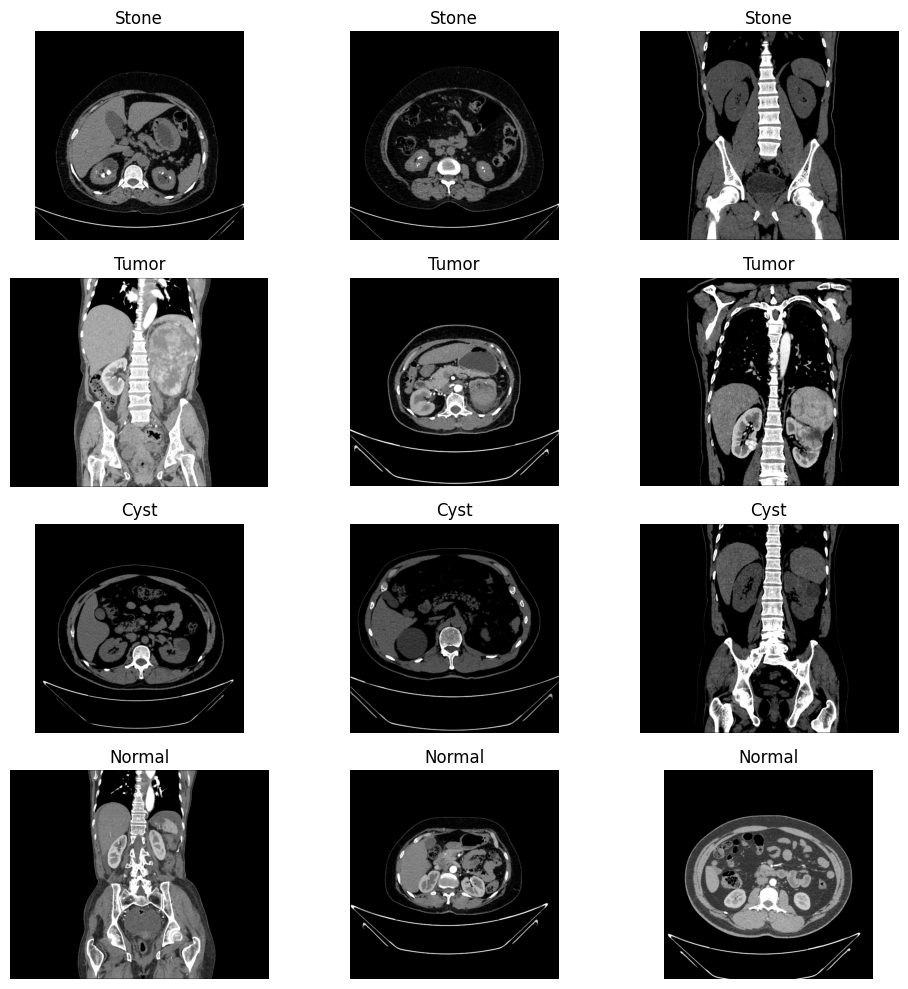

In [ ]:
# Visualisasi gambar per kelas
def samplesImages(base_dir, class_name):
    # Set ukuran plot
    fig, axes = plt.subplots(4, 3, figsize=(10, 10))

    # Looping semua kelas
    for i, label in enumerate(class_name):
        img_dir = os.path.join(base_dir, label)
        img_files = os.listdir(img_dir)
        sample_images = random.sample(img_files, 3)

        # Looping file gambar
        for j, img_file in enumerate(sample_images):
            img_path = os.path.join(base_dir, label, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(label)

    plt.tight_layout()
    plt.show()

# Panggil fungsi
samplesImages(base_dir, class_name)

In [ ]:
# Fungsi cek resolusi gambar
def imageResolutions(base_dir):
    # inisiasi variable untuk menampung output
    all_sizes = []
    class_info = {}
    total_images = 0

    # Looping semua folder
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)

        # Ambil semua gambar dalam folder
        if os.path.isdir(subdir_path):
            image_files = [f for f in os.listdir(subdir_path)]
            # Tambahkan jumlah gambar kedalam var total_images
            total_images += len(image_files)

            # Looping semua file gambar
            class_sizes = []
            for img_file in image_files:
                img_path = os.path.join(subdir_path, img_file)
                try:
                    with Image.open(img_path) as img:
                      # Ambil resolusi gambar
                        size = img.size
                    all_sizes.append(size) # Simpan resolusi gambar semua kelas
                    class_sizes.append(size) # Simpan resolusi gambar per kelas
                except Exception as e:
                    print(f'Error {img_file}: {e}')
            # Simpan daftar resolusi perkelas kedalam dictionary
            class_info[subdir] = class_sizes

    # Hitung distribusi resolusi setiap gambar
    size_counter = Counter(all_sizes)
    all_sizes_sorted = size_counter.most_common() # ubah menjadi descending
    print(f'Summary of Image Resolutions:')
    for i, ((w, h), count) in enumerate(all_sizes_sorted, 1):
        print(f'{i}. {w}x{h}: {count} images')
    print(f'\nTotal Images: {total_images}')

    return class_info, size_counter

# Panggil fungsi
class_info, size_distribution = imageResolutions(base_dir)

Summary of Image Resolutions:
1. 512x512: 7709 images
2. 798x646: 240 images
3. 804x651: 179 images
4. 768x622: 177 images
5. 840x680: 171 images
6. 764x619: 160 images
7. 1236x1001: 155 images
8. 787x636: 141 images
9. 705x569: 140 images
10. 882x714: 131 images
11. 701x566: 126 images
12. 745x602: 125 images
13. 867x701: 120 images
14. 809x655: 114 images
15. 854x691: 111 images
16. 828x670: 102 images
17. 755x611: 97 images
18. 1003x811: 95 images
19. 813x658: 93 images
20. 675x545: 88 images
21. 1221x988: 86 images
22. 910x737: 85 images
23. 824x667: 85 images
24. 808x654: 84 images
25. 791x640: 81 images
26. 730x591: 77 images
27. 888x719: 76 images
28. 697x564: 76 images
29. 680x550: 74 images
30. 672x544: 74 images
31. 785x634: 74 images
32. 1152x932: 70 images
33. 781x631: 69 images
34. 778x630: 67 images
35. 746x604: 66 images
36. 1060x858: 65 images
37. 758x614: 64 images
38. 713x576: 62 images
39. 790x640: 62 images
40. 892x722: 61 images
41. 869x702: 54 images
42. 796x644: 

In [ ]:
# Fungsi untuk membuat data frame
def makeDataframe(base_dir):
    data = []
    # Loop setiap folder kelas
    for label in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):

          # Looping tiap file gambar dalam kelas
            for file_name in os.listdir(class_dir):
                full_path = os.path.join(class_dir, file_name)
                data.append({
                    'file_path': full_path,
                    'file_name': file_name,
                    'label': label
                    })

    # Buat dataframe
    df = pd.DataFrame(data)
    return df

# Panggil fungsi
df = makeDataframe(base_dir)

### Data Preprocessing

####Split Dataset

In [ ]:
# Inisiasi fitur input dan target
X = df['file_path']
y = df['label']

# Split data test 10%
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

# Data validasi 20% dan train 70%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.22, stratify=y_temp, random_state=42
)

# Fungsi buat datframe setiap subset
def create_split_data(path, label, subset):
    return pd.DataFrame({'path': path, 'labels': label, 'subset': subset})

# Gunakan fungsi buat dataframe per subset
df_train = create_split_data(X_train, y_train, 'train')
df_val   = create_split_data(X_val, y_val, 'validation')
df_test  = create_split_data(X_test, y_test, 'test')

# Gabungkan subset
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

In [ ]:
df_all.head()

,path,labels,subset
0,CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-K...,Cyst,train
1,CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-K...,Stone,train
2,CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-K...,Normal,train
3,CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-K...,Tumor,train
4,CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-K...,Tumor,train


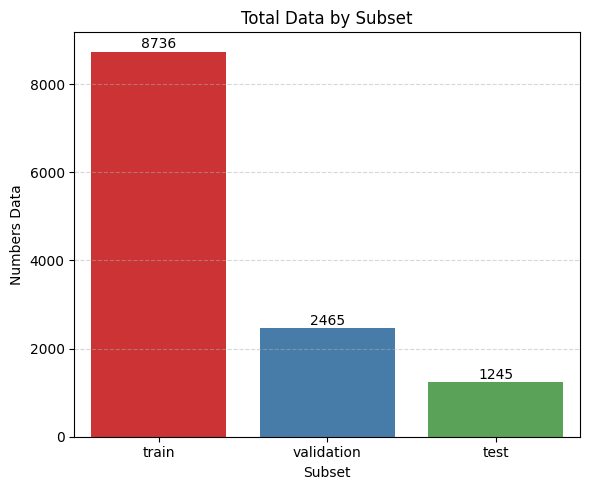

In [ ]:
# Visualisasi distribusi subset
def plotSubset(df_all, column='subset'):
    subset_counts = df_all[column].value_counts()

    # Plot bar chart
    plt.figure(figsize=(6, 5))
    sns.barplot(x=subset_counts.index, y=subset_counts.values, palette='Set1')

    # Tambahkan label jumlah di atas bar
    for i, val in enumerate(subset_counts.values):
        plt.text(i, val + 5, str(val), ha='center', va='bottom')

    plt.title('Total Data by Subset')
    plt.xlabel('Subset')
    plt.ylabel('Numbers Data')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plotSubset(df_all)

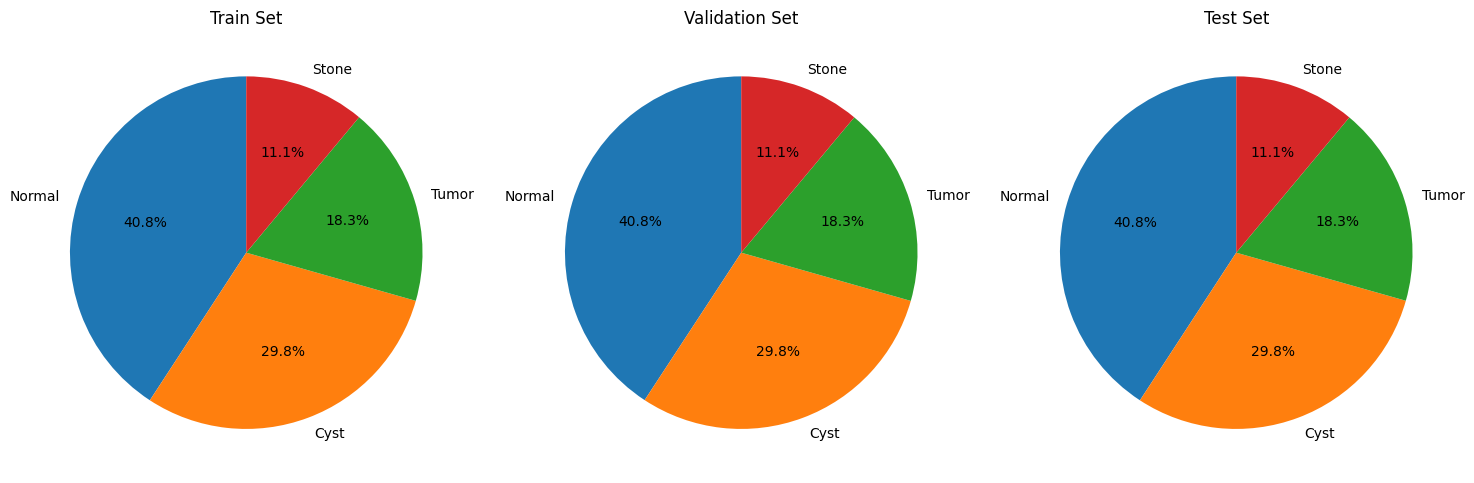

In [ ]:
# Fungsi visualisasi pie chart data per subset
def subsetProportion(df_all):
    plt.figure(figsize=(15, 5))

    # Loop semua subset
    for i, subset in enumerate(['train', 'validation', 'test'], 1):
        plt.subplot(1, 3, i)

        # Hitung distribusi kelas
        subset_pct = df_all[df_all['subset'] == subset]['labels'].value_counts(normalize=True) * 100

        # Plot pie chart
        plt.pie(
            subset_pct,
            labels=subset_pct.index,
            autopct='%1.1f%%',
            startangle=90
        )
        plt.title(f"{subset.capitalize()} Set")

    plt.tight_layout()
    plt.show()

# Panggil fungsi
subsetProportion(df_all)

In [ ]:
# Menampilkan distribusi data per subset
for i, subset in enumerate(['train', 'validation', 'test'], 1):
    subs = df_all[df_all['subset'] == subset]['labels'].value_counts()
    print('Total data by class:')
    print(f'{subset} {subs}')

Total data by class:
train labels
Normal    3564
Cyst      2603
Tumor     1603
Stone      966
Name: count, dtype: int64
Total data by class:
validation labels
Normal    1005
Cyst       735
Tumor      452
Stone      273
Name: count, dtype: int64
Total data by class:
test labels
Normal    508
Cyst      371
Tumor     228
Stone     138
Name: count, dtype: int64


In [ ]:
# Proses augmentasi gambar
# Augmentasi gambar pada data training
train_datagen = ImageDataGenerator(rescale=1./255, # Normalisasi pixel 0.1
                            rotation_range=10, # Rotasi gambar 10 derajat
                            width_shift_range=0.02, # geser horizontal 2%
                            height_shift_range=0.02, # geser vertikal 2%
                            zoom_range=0.05, # Zoom in/out 5%
                            brightness_range=[0.9, 1.1], # Buat variansi pencahayaan
                            fill_mode='nearest') # isi pixel kosong hasil tranformasi dengan pixel terdekat

# Hanya normalisasi pada data validation dan test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='path',
    y_col='labels',
    batch_size=64,
    target_size=(244, 244),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    df_val,
    x_col='path',
    y_col='labels',
    batch_size=64,
    target_size=(244, 244),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    seed=42
)

# Test generator
test_generator = val_test_datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='labels',
    batch_size=64,
    target_size=(244, 244),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    seed=42
)

Found 8736 validated image filenames belonging to 4 classes.
Found 2465 validated image filenames belonging to 4 classes.
Found 1245 validated image filenames belonging to 4 classes.


In [ ]:
# Perhitungan manual untuk memberikan bobot kepada kelas minoritas menggunakan inverse-sqrt frequency
# Encoding label ke int
classes, y_int = np.unique(y_train, return_inverse=True)
total_classes = len(classes)

# Hitung jumlah data dan gambar per kelas
class_count = np.bincount(y_int)
N_classes = len(y_int)

# Hitung bobot menggunakan inverse-sqrt frequency
sqrt_count = np.sqrt(class_count.astype(float))
c = N_classes / sqrt_count.sum()
w = c / sqrt_count

# Looping bobot setiap kelas didalam var w
class_weight = {i: float(w[i]) for i in range(total_classes)}
class_idx = train_generator.class_indices

# Tampilkan hasil
print('Total classes:', total_classes)
print('Total data by classes:', class_count)
print('Total data train:', N_classes)
print('Index class:',class_idx)
print('The calculated class weight:')
print(class_weight)

Total classes: 4
Total data by classes: [2603 3564  966 1603]
Total data train: 8736
Index class: {'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}
The calculated class weight:
{0: 0.941658836816206, 1: 0.8047515515719155, 2: 1.5457601508881982, 3: 1.1999520974467304}


## Modelling

In [ ]:
# Model sequential
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(244, 244, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 244, 244, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 242, 242, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 121, 121, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 121, 121, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 119, 119, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 59, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,428,516 (51.23 MB)

 Trainable params: 13,428,516 (51.23 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Fungsi custome callbacks
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96:
            print(f'\nModel telah mencapai target akurasi di epoch ke-{epoch+1}.')
            self.model.stop_training = True

# Panggil fungsi callback
custom_cb = CustomCallback()

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Fit latih model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight,
    callbacks=[custom_cb, early_stop]
)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.5794 - loss: 1.0992 - val_accuracy: 0.9075 - val_loss: 0.2365
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8881 - loss: 0.3242 - val_accuracy: 0.9712 - val_loss: 0.0744
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9535 - loss: 0.1437 - val_accuracy: 0.9919 - val_loss: 0.0300
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9662 - loss: 0.0921
Model telah mencapai target akurasi di epoch ke-4.
137/137 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9662 - loss: 0.0920 - val_accuracy: 0.9984 - val_loss: 0.0056
Restoring model weights from the end of the best epoch: 4.


## Evaluasi dan Visualisasi

<Figure size 640x480 with 0 Axes>

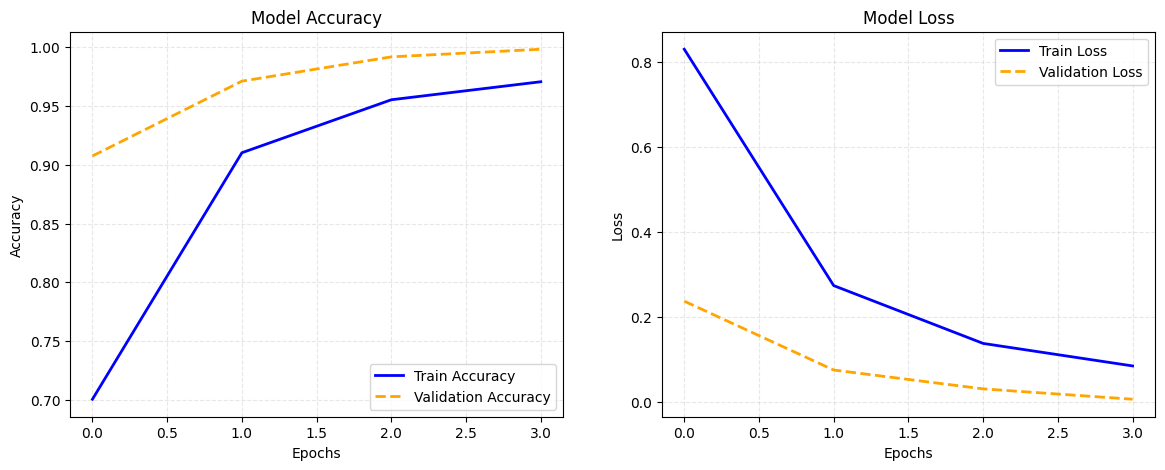

In [ ]:
# Fungsi menampilkan plot training dan loss model
def historyModel(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', linewidth=2)
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(linestyle='--', alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

historyModel(history)

In [ ]:
# Fungsi menampilkan metrik akurasi train, validasi dan test
def evaluateModel(model, train_generator, val_generator, test_generator):
    # Looping subset data
    for name, gen in[('train', train_generator), ('validation', val_generator), ('test', test_generator)]:
        # Hitung nilai akurasi dan loss
        loss, acc = model.evaluate(gen)

        # Tampilkan hasil
        print(f'{name.capitalize()} accuracy:{acc:.4f}')
        print(f'{name.capitalize()} loss: {loss:.4f}')

# Panggil fungsi
evaluateModel(model, train_generator, val_generator, test_generator)

137/137 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9933 - loss: 0.0212
Train accuracy:0.9929
Train loss: 0.0217
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - accuracy: 0.9977 - loss: 0.0071
Validation accuracy:0.9984
Validation loss: 0.0056
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 473ms/step - accuracy: 0.9976 - loss: 0.0083
Test accuracy:0.9968
Test loss: 0.0102


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step
Classification report:

              precision    recall  f1-score   support

        Cyst       1.00      0.99      1.00       371
      Normal       1.00      1.00      1.00       508
       Stone       0.99      0.99      0.99       138
       Tumor       1.00      1.00      1.00       228

    accuracy                           1.00      1245
   macro avg       1.00      1.00      1.00      1245
weighted avg       1.00      1.00      1.00      1245



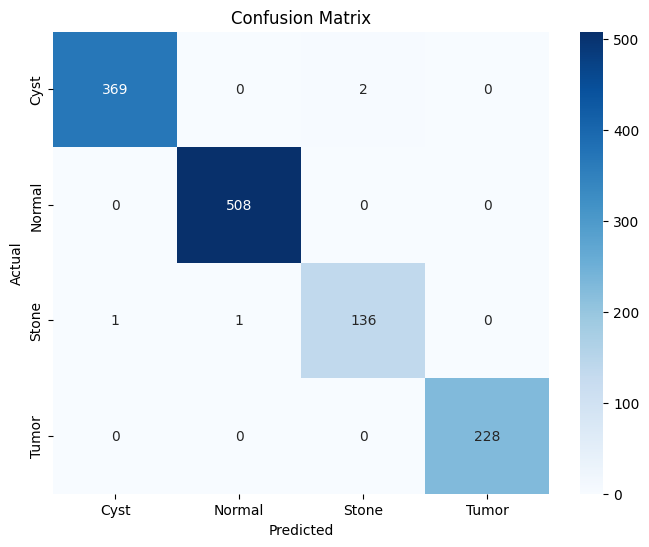

In [ ]:
# Fungsi menampilkan classification report dan plot confusion matrix
def modelReport(model, test_generator):

    # Ambil label kelas
    labels = test_generator.class_indices.keys()
    y_true = test_generator.classes # ambil label asli (int)

    # Prediksi probabilitas model
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    cm = confusion_matrix(y_true, y_pred)
    # classifiacation report
    print('Classification report:\n')
    print(classification_report(y_true, y_pred, target_names=labels))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

modelReport(model, test_generator)

<Figure size 640x480 with 0 Axes>

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step


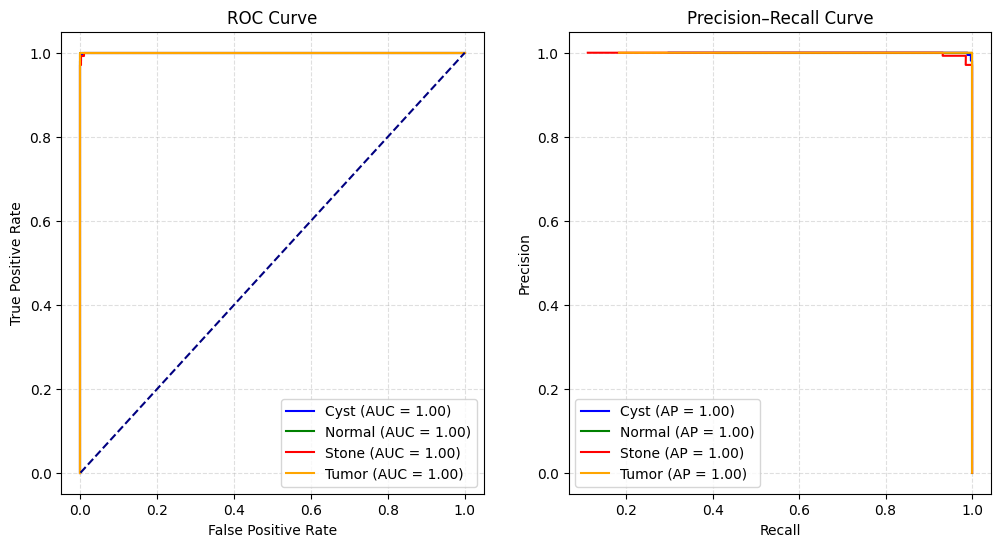

In [ ]:
# Fungsi menampilkan plot ROC dan PR Curves
def plot_roc_precision(model, test_generator):
    y_true = test_generator.classes # ambil label asli
    y_prob = model.predict(test_generator) # ambil output probabilitas dari model
    y_pred = np.argmax(y_prob, axis=1) # prediksi

    # Buat daftar nama kelas
    class_names = list(test_generator.class_indices.keys())
    n_classes = len(class_names)

    # One-hot encoding label asli
    y_true_bin = label_binarize(y_true, classes = range(n_classes))

    # Setup plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    colors = ['blue', 'green', 'red', 'orange']

    # Looping semua kelas untuk ROC
    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i]) # hitung FPR dan TPR
        roc_auc = auc(fpr, tpr) # tambahkan nilai AUC

        # Tambahkan garis dasar
        axes[0].plot(fpr, tpr, color=colors[i], label=f'{name} (AUC = {roc_auc:.2f})')

    # Visualisasi ROC curve
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='navy')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].grid(True, linestyle='--', alpha=0.4)
    axes[0].legend(loc='lower right')

   # Looping semua kelas untuk PR
    for i, name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i]) # Hitung nilai precision dan recall
        avg_p = average_precision_score(y_true_bin[:, i], y_prob[:, i]) # Tambahkan nilai AP
        axes[1].plot(precision, recall, color=colors[i], label=f'{name} (AP = {avg_p:.2f})')

     # Visualisasi Precision Recall Curve
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision–Recall Curve')
    axes[1].grid(True, linestyle='--', alpha=0.4)
    axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()

# Pangil fungsi
plot_roc_precision(model, test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step


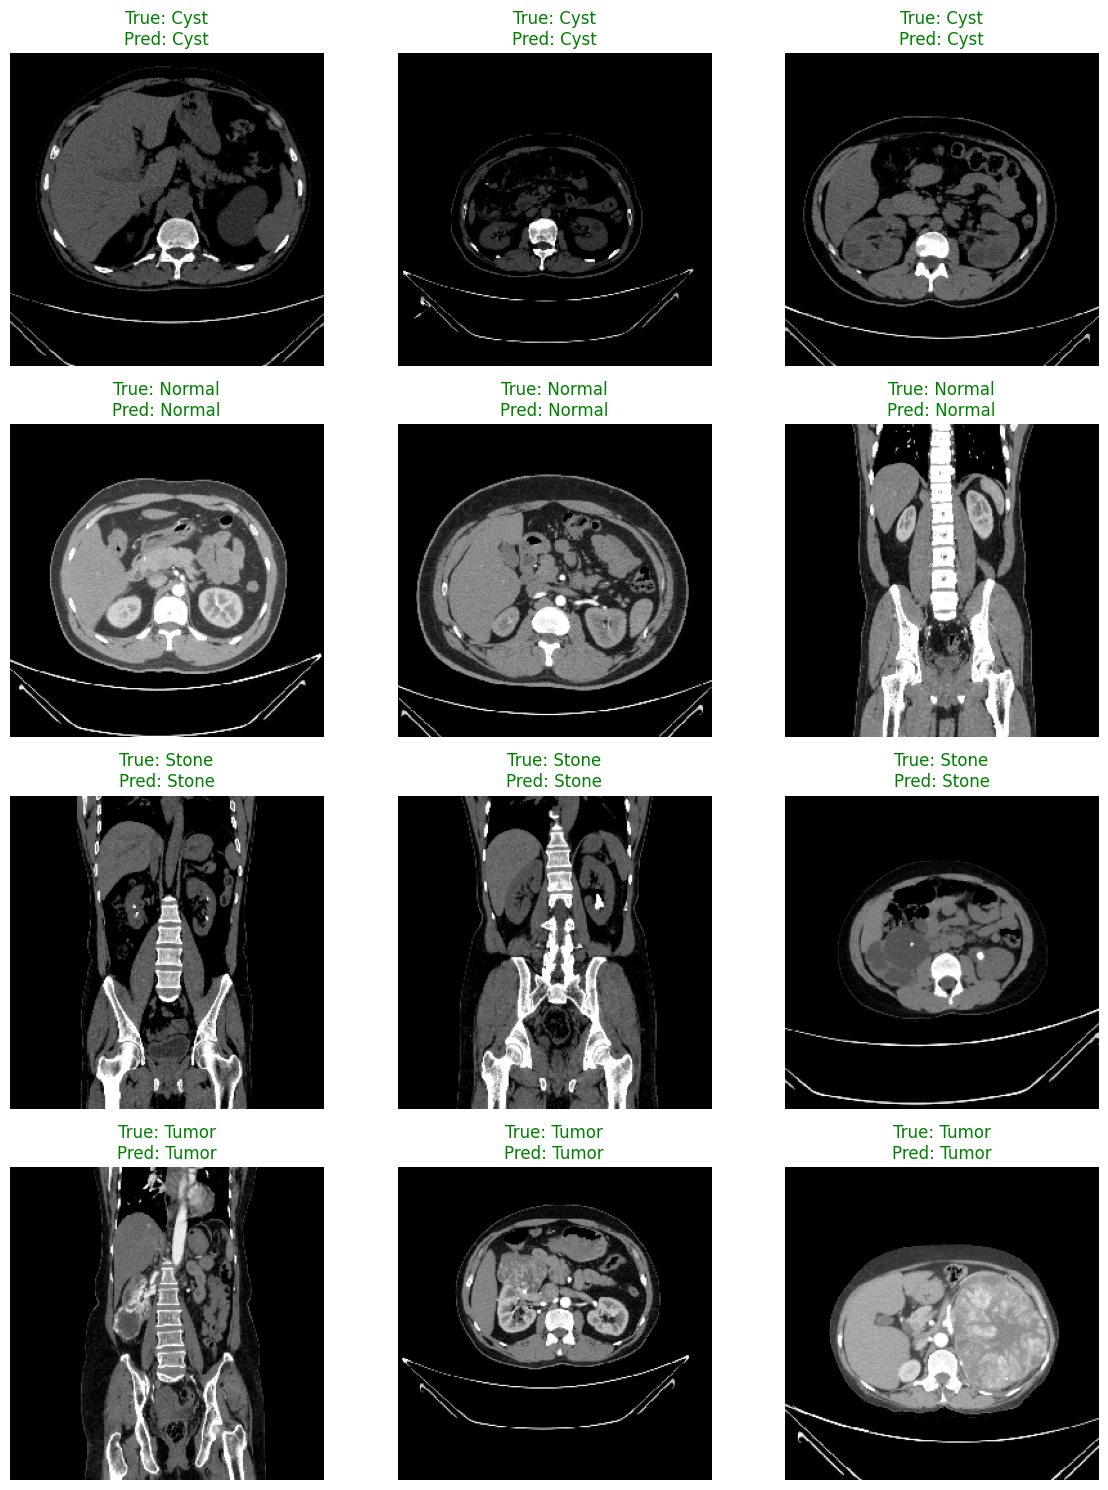

In [ ]:
# Fungsi menampilkan gambar sekaligus prediksi model
def showsPredicted(model, test_generator):
    # Prediksi probabilitas dan ambil label prediksi
    y_prob = model.predict(test_generator)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())

    # Ambil semua batch gambar dari test_generator
    all_images = []
    for i in range(len(test_generator)):
        images, i = next(test_generator)
        all_images.extend(images)

    # Satukan gambar dengan label asli & prediksi
    all_data = [(img, y_true[i], y_pred[i]) for i, img in enumerate(all_images)]

    # Setup plot
    fig, axes = plt.subplots(4, 3, figsize=(12, 15))

    # Loop tiap kelas
    for class_idx, name in enumerate(class_names):
        # Ambil data gambar sesuai kelas asli
        class_data = [item for item in all_data if item[1] == class_idx]
        selected_data = class_data[:3]  # pilih 3 contoh pertama
        for i in range(3):
            ax = axes[class_idx, i]
            if i < len(selected_data):
                img, true_label, pred_label = selected_data[i]
                true_name = class_names[true_label]
                pred_name = class_names[pred_label]
                ax.imshow(img)  # tampilkan gambar
                # Judul hijau prediksi benar, merah  salah
                color = 'green' if true_label == pred_label else 'red'
                ax.set_title(f'True: {true_name}\nPred: {pred_name}', color=color, fontsize=12)
                ax.axis('off')  # hilangkan axis

    plt.tight_layout()
    plt.show()

# Panggil fungsi
showsPredicted(model, test_generator)

## Konversi Model

In [ ]:
# Save model default tensorflow
save_path = '/content/save_model'
model.export(save_path)
print(f'Model berhasil diexport ke {save_path}')

# Kompres folder ke .zip
!zip -r /content/save_model.zip /content/save_model

# Download model
files.download('/content/save_model.zip')

 (deflated 7%)
  adding: content/save_model/variables/variables.index (deflated 67%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save model menggunakan format tfjs
tfjs_path = 'tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_path)
print(f'Model berhasil disimpan di {tfjs_path}')

In [ ]:
# Download model tfjs
!zip -r /content/tfjs_model.zip /content/tfjs_model
files.download('/content/tfjs_model.zip')

In [ ]:
# save model menggunakan format tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_path = 'model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f'Model berhasil disimpan di {tflite_path}')

## Inference (Optional)

Predicted: Stone
Confidence Score: 100.00%



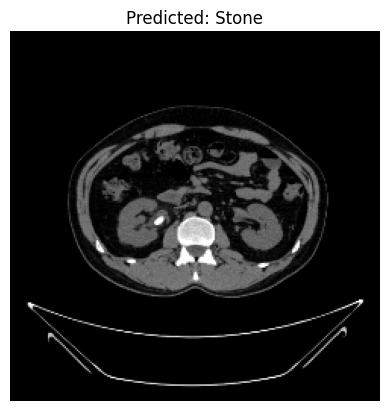

In [ ]:
# Inisiasi daftar nama kelas
CLASS_NAMES = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Format ukuran target input gambar
IMG_SIZE = (244, 244)

# Load saved model TensorFlow untuk inference
loaded = tf.saved_model.load(save_path)
infer = loaded.signatures['serving_default']          # fungsi default untuk prediksi
input_key = list(infer.structured_input_signature[1].keys())[0]  # ambil nama tensor input

# Fungsi preprocessing gambar
def preprocess(path):
    x = tf.io.read_file(path)                         # baca file gambar
    x = tf.image.decode_image(x, channels=3, expand_animations=False)  # decode jadi RGB
    x = tf.image.resize(x, IMG_SIZE)                  # resize ke ukuran model
    x = tf.cast(x, tf.float32) / 255.0                # normalisasi ke range [0,1]
    return tf.expand_dims(x, 0)                       # tambahkan dimensi batch

# Fungsi prediksi gambar baru
def predict_image(path):
    x = preprocess(path)                              # preprocess gambar
    out = infer(**{input_key: x})                     # jalankan inference model
    probs = list(out.values())[0].numpy()[0]          # ambil output probabilitas
    idx = int(np.argmax(probs))                       # kelas dengan probabilitas tertinggi
    pct = probs[idx] * 100                            # confidence score (%)
    print(f'Predicted: {CLASS_NAMES[idx]}')           # cetak kelas hasil prediksi
    print(f'Confidence Score: {pct:.2f}%\n')
    plt.imshow(x[0])                                  # tampilkan gambar
    plt.title(f'Predicted: {CLASS_NAMES[idx]}')       # judul = hasil prediksi
    plt.axis('off'); plt.show()                       # hilangkan axis

# Prediksi gambar
predict_image('/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (1).jpg')

In [ ]:
# # install requirements.txt library yang digunakan dalam proyek ini

# packages = [
#     "numpy",
#     "pandas",
#     "matplotlib",
#     "seaborn",
#     "opencv-python",
#     "Pillow",
#     "scikit-learn",
#     "tensorflow",
#     "tensorflowjs"
# ]

# with open('requirements.txt', 'w') as f:
#     for pkg in packages:
#         try:
#             v = __import__(pkg.replace('-', '_')).__version__
#             f.write(f'{pkg} == {v}\n')
#         except:
#             f.write(f'{pkg}\n')
# !cat requirements.txt

numpy == 2.0.2
pandas == 2.2.2
matplotlib == 3.10.0
seaborn == 0.13.2
opencv-python
Pillow
scikit-learn
tensorflow == 2.19.0
tensorflowjs == 4.22.0
